In [21]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from enum import Enum
import numpy as np
import random
import sys

In [22]:
#Vaaccine Given
#Recovery rate = 90%
#Avaliablity = 50%

class Stage(Enum):
    NON_INFECTED = 1
    INFECTED_ASYMTOMATIC = 2
    INFECTED_SYMTOMATIC = 3
    CRITICAL = 4
    CURED = 5
    DECEASED = 6
    VACCINATED = 7
    

class Location(Enum):
    HOME = 1
    PARK = 2
    GROCERY_STORE = 3
    QUARANTINE_CENTER = 4

In [47]:
class Person(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model, home_id):
        super().__init__(unique_id, model)
        self.homeId = home_id
        self.location = Location.HOME
        self.stage = Stage.NON_INFECTED
        self.in_quarantine = False
        self.locationId = home_id
        self.develope_antibodies = False

    def move_to_next(self):
        # If a person is infected
        if self.infected():
            self.while_infected()
            
        if self.location == Location.PARK or self.location == Location.GROCERY_STORE:
            self.location = Location.HOME
            self.locationId = self.homeId
        elif self.location == Location.HOME:
            if self.random.random() < 0.70:
                pass
            else:
                if self.random.random() < 0.33:
                    self.location = Location.PARK
                    parkId = random.randint(1, 2)
                    self.locationId = parkId
                else:
                    self.location = Location.GROCERY_STORE
                    storeId = random.randint(1, 5)
                    self.locationId = storeId
        
    def set_quarantine(self):
        ''' Person has been infected and in quarantine '''
        if self.model.quarantine_center.add_members():
            self.in_quarantine = True
            self.location = Location.QUARANTINE_CENTER
            self.locationId = 1
        
    def set_infected(self):
        self.stage = Stage.INFECTED_ASYMTOMATIC
        
    def setContagiousEffect(self, members):
        if self.in_quarantine == True:
            return
        
        for member in members:
            if member.stage == Stage.NON_INFECTED:
                if self.random.random() < self.model.infect_rate:
                    member.stage = Stage.INFECTED_ASYMTOMATIC
            if member.stage == Stage.CURED:
                if self.random.random() < 0.99:
                    member.stage = Stage.INFECTED_ASYMTOMATIC

    def infect_others(self):
        ''' Infect others in same area based on infection rate '''
        locationId = self.locationId
        locationIndex = locationId - 1
        members = []
        
        if self.location == Location.PARK:
            members = self.model.parks[locationIndex].members_in_park()
        elif self.location == Location.GROCERY_STORE:
            members = self.model.grocery_stores[locationIndex].members_in_store()
        elif self.location == Location.HOME:
            members = self.model.homes[locationIndex].homemates()
        else:
            return
        self.setContagiousEffect(members)
            
            

    def while_infected(self):
        ''' While infected, infect others, see if die from infection or recover '''
        self.infect_others()
        
        if self.stage == Stage.INFECTED_ASYMTOMATIC:
            if self.random.random() < 0.25:
                self.stage = Stage.INFECTED_SYMTOMATIC
                if self.random.random() < 0.20:
                    self.set_quarantine()
        
        elif self.stage == Stage.INFECTED_SYMTOMATIC:
            if self.random.random() < 0.25:
                if self.random.random() < 0.40:
                    self.stage = Stage.CRITICAL
                    if self.in_quarantine == False:
                       self.set_quarantine() 
                else:
                    self.stage = Stage.CURED
                    if self.in_quarantine == True:
                        self.model.quarantine_center.discharge_members()
                        self.location = Location.HOME
                        self.locationId = self.homeId
                        self.develope_antibodies = True
            else:
                if self.random.random() < 0.50:
                    if self.model.available_vaccines > 0 and not self.develope_antibodies:
                        self.stage = Stage.VACCINATED
                        self.model.available_vaccines -= 1
        
        elif self.stage == Stage.CRITICAL:
            if self.random.random() < 0.25:
                if self.random.random() < 0.75:
                    if self.model.available_vaccines > 0:
                        self.stage = Stage.VACCINATED
                        self.model.available_vaccines -= 1
                else:
                    if self.random.random() < 0.25:
                        if self.develope_antibodies == True and self.random.random() < 0.95:
                            self.stage = Stage.CURED
                            if self.in_quarantine == True:
                                self.model.quarantine_center.discharge_members()
                                self.location = Location.HOME
                                self.locationId = self.homeId
                                self.develope_antibodies = True
                        else:
                            self.stage = Stage.DECEASED
                            if self.in_quarantine == True:
                                self.model.quarantine_center.discharge_members()
                    else:
                        self.stage = Stage.CURED
                        if self.in_quarantine == True:
                            self.model.quarantine_center.discharge_members()
                            self.location = Location.HOME
                            self.locationId = self.homeId
                            self.develope_antibodies = True
            else:
                if self.model.available_vaccines > 0 and not self.develope_antibodies:
                    self.stage = Stage.VACCINATED
                    self.model.available_vaccines -= 1
                
        
        elif self.stage == Stage.VACCINATED:
            if self.random.random() < 0.90:
                self.stage = Stage.CURED
                if self.in_quarantine == True:
                    self.model.quarantine_center.discharge_members()
                    self.location = Location.HOME
                    self.locationId = self.homeId
            else:
                if self.random.random() < 0.90:
                    self.stage = Stage.INFECTED_SYMTOMATIC
                else:
                    self.stage = Stage.CRITICAL

    def move(self):
        # Move to a new position if not in quarantine
        if self.in_quarantine:
            self.while_infected()
        else:
            self.move_to_next()

    def step(self):
        if self.stage == Stage.DECEASED:
            return
        self.move()
            
    def infected(self):
        if self.stage == Stage.NON_INFECTED or self.stage == Stage.CURED or self.stage == Stage.DECEASED:
            return False
        else:
            return True

In [48]:
class Home(Agent):
    def __init__(self, unique_id, model):
        # initialize the parent class with required parameters
        super().__init__(unique_id, model)

    def homemates(self):
        # unique ids of homemates
        agents = []
        for agent in model.schedule.agents:
            if agent.location == Location.HOME and agent.locationId == self.unique_id:
                agents.append(agent)
        return agents

In [49]:
class Park(Agent):
    def __init__(self, unique_id, model):
        # initialize the parent class with required parameters
        super().__init__(unique_id, model)

    def members_in_park(self):
        agents = []
        for agent in model.schedule.agents:
            if agent.location == Location.PARK and agent.locationId == self.unique_id:
                agents.append(agent)
        return agents

In [50]:
class GroceryStore(Agent):
    def __init__(self, unique_id, model):
        # initialize the parent class with required parameters
        super().__init__(unique_id, model)

    def members_in_store(self):
        agents = []
        for agent in model.schedule.agents:
            if agent.location == Location.GROCERY_STORE and agent.locationId == self.unique_id:
                agents.append(agent)
        return agents

In [51]:
class QuarantineCenter(Agent):
    def __init__(self, unique_id, model, available_beds):
        # initialize the parent class with required parameters
        super().__init__(unique_id, model)
        self.available_beds = available_beds

    def add_members(self):
        if self.available_beds == 0:
            return False
        
        self.available_beds = self.available_beds - 1
        return True
        
    def discharge_members(self):
        self.available_beds = self.available_beds + 1

In [52]:
from mesa import Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt

def total_infected(model):
    total = 0
    for agent in model.schedule.agents:
        if agent.infected():
            total += 1
    return total

def total_deaths(model):
    total = 0
    for agent in model.schedule.agents:
        if agent.stage == Stage.DECEASED:
            total += 1
    return total

def total_immune(model):
    total = 0
    for agent in model.schedule.agents:
        if agent.stage == Stage.CURED or agent.develope_antibodies:
            total += 1
    return total

def beds_used(model):
    return model.available_vaccines

class Simulation(Model):
    """A model with some number of agents."""
    def __init__(self, params, seed=None):
        self.num_agents = params.get('num_persons')
        self.schedule = RandomActivation(self)
        self.running = True
        self.current_cycle = 0
        self.start_infected = params.get('initial_infected')
        self.infect_rate = params.get('infect_rate')
        self.available_beds = params.get('available_beds')
        self.available_vaccines = params.get('available_vaccines')
        self.quarantine_center = QuarantineCenter(1, self, self.available_beds)
        
        self.parks = []
        self.parks.append(Park(1, self))
        self.parks.append(Park(2, self))
        
        self.grocery_stores = []
        for i in range(1,6,1):
            self.grocery_stores.append(GroceryStore(i, self))
            
        
        number_of_homes = self.num_agents // 4 + 1
        self.homes = []
        personID = 1
        for i in range(1, number_of_homes, 1):
            self.homes.append(Home(i, self))
            for j in range(4):
                a = Person(personID, self, i)
                personID = personID + 1
                if self.random.random() < self.start_infected:
                    a.set_infected()
                self.schedule.add(a)

        self.datacollector = DataCollector(
            model_reporters={
                "Infected": total_infected,
                "DECEASED": total_deaths,
                "Cured": total_immune,
            })

    def step(self):
        '''Advance the model by one step.'''
        self.datacollector.collect(self)
        self.schedule.step()
        self.current_cycle += 1

    Infected  DECEASED  Cured
0        110         0      0
1        268         0      0
2        645         0      0
3        846         0     10
4        929         3     18
5        958         4     25
6        953         4     40
7        956         4     40
8        974         4     22
9        972         6     22
10       977         8     15
11       977        11     12
12       967        14     19
13       966        16     18
14       956        22     22
15       958        24     18
16       957        31     12
17       959        32      9
18       953        36     11
19       939        42     19
20       925        51     24
21       931        56     13
22       917        62     21
23       904        71     25
24       901        80     19
25       897        86     17
26       891        98     11
27       877       108     15
28       863       114     23
29       868       117     15
30       854       126     20
31       849       133     18
32       8

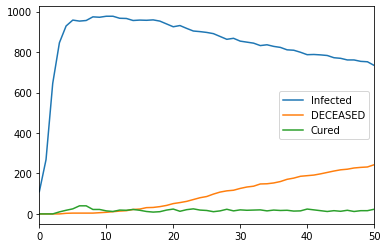

In [53]:
# Simulation parameters
sim_params = {
    "num_persons": 1000,  # number of persons in simulation
    "initial_infected": 0.10,  # initial percentage of population infected
    "cycles": 50,  # cycles to run, 0 for infinity
    "infect_rate": 0.5,
    "available_beds": 0,
    "available_vaccines": 500,
}  # end of parameters

model = Simulation(sim_params)
current_cycle = 0
cycles_to_run = sim_params.get('cycles')
#print(cycles_to_run)
#print(sim_params)
while 1:
    model.step()
    if cycles_to_run > 0 and current_cycle >= cycles_to_run:
        break
    current_cycle += 1

model_data = model.datacollector.get_model_vars_dataframe()
model_data.plot()
print(model_data)
plt.show()